# Group Project - Financial Programming
### Fernado DELGADO - Hina HUSSAIN - Nixia Sancy JOHN

![CoverPhoto](../img/CoverPhoto.jpg)

In [1]:
!pip install squarify

In [2]:
# Import libraries
import squarify
import warnings
import numpy                 as np
import pandas                as pd
import matplotlib.pyplot     as plt
import plotly                as plty
import plotly.express        as px
import datetime              as dt
import statsmodels.api       as sm
import plotly.graph_objects  as go
from plotly.subplots         import make_subplots
from scipy.stats             import pearsonr
from scipy.stats.mstats      import winsorize
from dateutil.relativedelta  import relativedelta
from pandas.tseries.offsets  import DateOffset
from pandas.api.types        import is_numeric_dtype
from sklearn.linear_model    import LogisticRegression
from sklearn.model_selection import train_test_split


In [3]:
warnings.filterwarnings('ignore')

## Import Data

###### Relational Database Model
![RelationalDatabase](../img/RelationalDatabase.png)

In [4]:
# Import banking data
# Note: This data was extracted on 1999

# Each record describes characteristics of a client
client = pd.read_csv('../data/raw/data_berka/client.asc', sep=';') 

# Each record describes static characteristics of an account
account = pd.read_csv('../data/raw/data_berka/account.asc', sep=';')

# Each record describes a credit card issued to an account
card = pd.read_csv('../data/raw/data_berka/card.asc', sep=';')

# Each record describes demographic characteristics of a district
district = pd.read_csv('../data/raw/data_berka/district.asc', sep=';')

# Each record relates together a client with an account
# i.e. this relation describes the rights of clients to operate accounts
disp = pd.read_csv('../data/raw/data_berka/disp.asc', sep=';')

# Each record describes characteristics of a payment order (debits only)
order = pd.read_csv('../data/raw/data_berka/order.asc', sep=';')

# Each record describes one transaction on an account
trans = pd.read_csv('../data/raw/data_berka/trans.asc', sep=';', low_memory=False)

# Each record describes a loan granted for a given account
loan = pd.read_csv('../data/raw/data_berka/loan.asc', sep=';')

## Data Preparation

## Client Table

In [5]:
#Extract Age, gender and birth month

# Transform the birth day into year
client['birth_year'] = '19' + client['birth_number'].astype(str).str[:2]
client['birth_year'] = client['birth_year'].astype(int)

# Transform the birth day to day
client['birth_day'] = client['birth_number'].astype(str).str[-2:].astype(int)

# Extract the birth month
client['birth_month'] = client['birth_number'].astype(str).str[2:4].astype(int)

# Extract and correct the gender
client['gender'] = 'M'
client.loc[client['birth_month'] > 50, 'gender'] = 'F'

# Correct the birth month
client.loc[client['birth_month'] > 50, 'birth_month'] = client.loc[client['birth_month'] > 50, 'birth_month'] - 50


# Age
client['age'] = 1996 - client['birth_year']

# Age group
client['age_group'] = 'Seniors'
client.loc[(client['age'] >= 0) & (client['age'] <= 14), 'age_group'] = 'Children'
client.loc[(client['age'] >= 15) & (client['age'] <= 24), 'age_group'] = 'Youth'
client.loc[(client['age'] >= 25) & (client['age'] <= 64), 'age_group'] = 'Adults'


# drop unwanted columns
client = client.drop('birth_number', axis =1)

client.head()

,client_id,district_id,birth_year,birth_day,birth_month,gender,age,age_group
0,1,18,1970,13,12,F,26,Adults
1,2,1,1945,4,2,M,51,Adults
2,3,1,1940,9,10,F,56,Adults
3,4,5,1956,1,12,M,40,Adults
4,5,5,1960,3,7,F,36,Adults


In [6]:
#Interim table
client_merge = client

## Account Table

In [7]:
#Get year from account created date
account['acc_created_year'] = account['date'].astype(str).str[:2].astype(int) + 1900

#Filter for accounts created before 1996
account = account[account['acc_created_year'] < 1996]

#Get Length of Relationship
account['lor'] = 1996 - account['acc_created_year']

#Rename the frequency column name and variable names

account = account.rename(columns={'frequency': 'Statement Frequency', 'district_id':'branch_district_id'})

account['Statement Frequency'] = account['Statement Frequency'].map({'POPLATEK MESICNE': 'Monthly',
                                                 'POPLATEK TYDNE'  : 'Weekly'
                                                 ,'POPLATEK PO OBRATU' : 'After Trans'})   


#Account Date
account['acc_date'] =  pd.to_datetime(account['date'], format='%y%m%d')
account = account.drop(columns='date')
account.head()


,account_id,branch_district_id,Statement Frequency,acc_created_year,lor,acc_date
0,576,55,Monthly,1993,3,1993-01-01
1,3818,74,Monthly,1993,3,1993-01-01
2,704,55,Monthly,1993,3,1993-01-01
3,2378,16,Monthly,1993,3,1993-01-01
4,2632,24,Monthly,1993,3,1993-01-02


In [8]:
#Interim table
account_merge = account

## Loan Table

In [9]:
#Get year loan was granted
loan['loan_issue_year'] = loan['date'].astype(str).str[:2].astype(int) + 1900
loangrant_97 = loan[loan['loan_issue_year'] == 1997]
loan = loan[loan['loan_issue_year'] == 1996]
#Get dummy variables for each loan status
loan = loan.join(pd.get_dummies(loan['status'], drop_first = False))

#Rename the dummy variable columns
loan = loan.rename(columns={'A': 'contract_finished_on_track', 'B' : 'contract_finished_not_on_track', 'C' : 'running_contract_on_track','D':'running_contract_not_on_track'})

#Rename the columns
loan = loan.rename(columns={"amount": "loan_amount"
                                       ,"duration": "loan_duration_months","payments": "loan_monthly_payment"})

# drop status column
loan = loan.drop('status', axis=1)

#Loan
loan['loan_date'] =  pd.to_datetime(loan['date'], format='%y%m%d')

#Calculate duration left and amount left to pay as on 1996/12/31
loan['completed_year'] = loan['loan_date'] + loan['loan_duration_months'].apply(pd.offsets.WeekOfMonth)
loan['year_end'] = dt.date(1996,12,31)
loan['duration_left'] = (12 * (pd.DatetimeIndex(loan['completed_year']).year - pd.DatetimeIndex(loan['year_end']).year)) + (pd.DatetimeIndex(loan['completed_year']).month - pd.DatetimeIndex(loan['year_end']).month)
loan['duration_left'] = np.where(loan['duration_left'] < 0,0,loan['duration_left'])

loan['amount_left_to_pay'] = loan['duration_left'] * loan['loan_monthly_payment']
loan.head()


,loan_id,account_id,date,loan_amount,loan_duration_months,loan_monthly_payment,loan_issue_year,contract_finished_on_track,contract_finished_not_on_track,running_contract_on_track,running_contract_not_on_track,loan_date,completed_year,year_end,duration_left,amount_left_to_pay
211,6589,7815,960101,189696,24,7904.0,1996,1,0,0,0,1996-01-01,1998-01-05,1996-12-31,13,102752.0
212,5900,4503,960101,135360,48,2820.0,1996,0,0,1,0,1996-01-01,2000-01-03,1996-12-31,37,104340.0
213,5999,4907,960103,98832,48,2059.0,1996,0,0,1,0,1996-01-03,2000-01-03,1996-12-31,37,76183.0
214,6043,5126,960111,20352,48,424.0,1996,0,0,1,0,1996-01-11,2000-01-03,1996-12-31,37,15688.0
215,5482,2496,960112,165120,60,2752.0,1996,0,0,1,0,1996-01-12,2001-01-01,1996-12-31,49,134848.0


In [10]:
#Interim Table
loan_merge = loan[['account_id','loan_amount','loan_duration_months','duration_left','amount_left_to_pay']]

## Transactions Table

In [11]:
# Filter for transactions in 1996 
trans = trans[trans['date'].astype(str).str[:2].isin(['96'])]

# Extract the transaction year
trans['trans_year'] = 1900 + trans['date'].astype(str).str[:2].astype(int)

# Aggregate the total credit per account
trans_agg_credit = trans[trans['type'].isin(['PRIJEM'])].groupby('account_id')['amount'].agg('sum')
trans_agg_credit = trans_agg_credit.reset_index()
trans_agg_credit = trans_agg_credit.rename(columns={'amount':'total_credit_per_account'})


# Aggregate the total withdrawal per account
trans_agg_withdrawal = trans[trans['type'].isin(['VYDAJ', 'VYBER'])].groupby('account_id')['amount'].agg('sum')
trans_agg_withdrawal = trans_agg_withdrawal.reset_index()
trans_agg_withdrawal = trans_agg_withdrawal.rename(columns={'amount':'total_withdrawal_per_account'})

#Merge the aggregates with the main trans table
trans = pd.merge(trans, trans_agg_credit, how='left', on='account_id')
trans = pd.merge(trans, trans_agg_withdrawal, how='left', on='account_id')

# Fix the NA and blank values in k_symbol column
trans.k_symbol = trans.k_symbol.fillna('OTHERS')
trans.k_symbol[trans.k_symbol == ' '] = 'OTHERS'

#Make a new column for transaction type
trans['transaction'] = 'withdrawal'
trans.loc[trans['type'] == 'PRIJEM', 'transaction'] = 'credit'


#Rename the columns
trans = trans.rename(columns={"date": "trans_date"
                                       ,"type": "trans_type","operation": "trans_operation", "amount": "trans_amount", "balance":"balance_after_trans"})


trans.trans_operation = trans.trans_operation.fillna('OTHERS')
trans.trans_operation[trans.trans_operation == ' '] = 'OTHERS'

#Total number of transactions
total_trans = trans.groupby('account_id')['trans_id'].agg('count')
total_trans = total_trans.reset_index()
total_trans = total_trans.rename(columns={'trans_id':'total_trans'})
trans = pd.merge(trans,total_trans,how='left',on='account_id')
trans.head()

#Opening Balance of the Year
trans_amb = trans.sort_values(by=['account_id','trans_date'])
trans_amb_opening = trans_amb.groupby('account_id')['account_id','balance_after_trans','trans_amount'].head(1)
trans_amb_opening['opening_balance'] = trans_amb_opening['balance_after_trans'] + trans_amb_opening['trans_amount']

#Closing Balance of the Year
trans_amb_closing = trans_amb.groupby('account_id')['account_id','balance_after_trans'].tail(1)
trans_amb_closing = trans_amb_closing.rename(columns={'balance_after_trans':'closing_balance'})

#Merge to main trans table
trans = pd.merge(trans,trans_amb_opening[['account_id','opening_balance']],how='left',on='account_id')
trans = pd.merge(trans,trans_amb_closing[['account_id','closing_balance']],how='left',on='account_id')

#Calculate total amount for each operation type
oper_type = trans['trans_operation'].unique()
oper_type_map = {'VYBER KARTOU':'total_credit_card_withdrawal','VKLAD':'total_credit_cash','PREVOD Z UCTU':'total_collection_other_bank','VYBER':'total_withdrawal_cash','PREVOD NA UCET':'total_remittance_to_bank','OTHERS':'total_miscellaneous'}
for ops in oper_type:
    trans_cc_w = trans[trans['trans_operation'] == ops].groupby('account_id')['trans_amount'].agg('sum')
    trans_cc_w = trans_cc_w.reset_index()
    trans_cc_w = trans_cc_w.rename(columns={'trans_amount':oper_type_map[ops]})
    trans = pd.merge(trans,trans_cc_w,how='left',on='account_id')
trans.head()

#Transaction Date
trans['trans_date'] =  pd.to_datetime(trans['trans_date'], format='%y%m%d')

# --------------------------------Calculate Recency-------------------------------------------------------------
#Select Max date
trans_recency = trans[trans.groupby('account_id').trans_date.transform('max') == trans['trans_date']]
#Subset Columns
trans_recency = trans_recency[['account_id', 'trans_date']]
#Rename Columns
trans_recency = trans_recency.rename(columns={"trans_date": "max_date"})
#merge with transactions table
trans = pd.merge(trans, trans_recency, how='left', on='account_id')
#recency column
trans['recency'] = pd.to_datetime('1996-12-31') - trans['max_date']
#cast to string
trans['recency'] = trans['recency'].astype(str)
#split string
trans.recency = trans.recency.str.split( ).str[0]
#cast back to float
trans['recency'] = trans['recency'].astype(float)

#----------------------------Calculate Frequency------------------------------------------------------------------
#Count transactions
total_trans = trans.groupby('account_id')['trans_id'].agg('count')
#Remove Index
total_trans = total_trans.reset_index()
#Rename column
total_trans = total_trans.rename(columns={'trans_id':'frequency'})
#Merge with transactions table
trans = pd.merge(trans,total_trans,how='left',on='account_id')

#--------------------------Monetary Value ------------------------------------------------------------------------
#Create dummy column
trans['monetaryvalue'] = 0
#Sum credit and withdrawal
trans['credit_withdrawal'] = trans['total_withdrawal_per_account'] + trans['total_credit_per_account']
#create monetary value column without null values
trans.loc[trans['credit_withdrawal'].notnull(), 'monetaryvalue'] = trans['credit_withdrawal']
#drop extra column
trans = trans.drop(['credit_withdrawal'], axis=1)
#------------------------------------------------------------------------------------------------------------------

#Treat missing values for the trans table
ismissing_trans = trans.columns[trans.isnull().any()]
ismissing_trans
#Fill values to for missing values
for col in ismissing_trans:
    if is_numeric_dtype(trans[col]):
        trans[col] = trans[col].fillna(0)
        
trans.head()


,trans_id,account_id,trans_date,trans_type,trans_operation,trans_amount,balance_after_trans,k_symbol,bank,account,...,total_credit_card_withdrawal,total_withdrawal_cash,total_credit_cash,total_remittance_to_bank,total_collection_other_bank,total_miscellaneous,max_date,recency,frequency,monetaryvalue
0,732811,2504,1996-01-01,VYDAJ,VYBER KARTOU,900.0,38124.4,OTHERS,NaN,0.0,...,28600.0,220675.2,303888.0,66156.0,0.0,1796.3,1996-12-31,0.0,146,621115.5
1,732811,2504,1996-01-01,VYDAJ,VYBER KARTOU,900.0,38124.4,OTHERS,NaN,0.0,...,28600.0,220675.2,303888.0,66156.0,0.0,1796.3,1996-12-31,0.0,146,621115.5
2,800209,2729,1996-01-01,VYDAJ,VYBER,1920.0,34202.7,OTHERS,NaN,0.0,...,0.0,76615.2,195200.0,104796.0,0.0,1849.3,1996-12-31,0.0,152,378460.5
3,800209,2729,1996-01-01,VYDAJ,VYBER,1920.0,34202.7,OTHERS,NaN,0.0,...,0.0,76615.2,195200.0,104796.0,0.0,1849.3,1996-12-31,0.0,152,378460.5
4,803553,2738,1996-01-01,VYDAJ,VYBER,6500.0,25685.2,OTHERS,NaN,0.0,...,0.0,86075.2,186290.0,106968.0,0.0,1391.6,1996-12-31,0.0,172,380724.8


In [12]:
#Interim table
trans_merge = trans.drop_duplicates(subset='account_id')
trans_merge = trans_merge.drop(columns=['trans_id','transaction','trans_date','trans_type','trans_operation','trans_amount','balance_after_trans','k_symbol','bank','account','trans_year'])

## District Table

In [13]:
#Drop A12(unemployment in 95) and A15 (crimes in 95)
district = district.drop(columns=['A12','A15'])

#Rename columns
district = district.rename(columns={'A1': 'district_id','A2': 'district_name','A3':'region','A4':'no_of_inhabitants','A5':'municipalities_pop<499',
                                    'A6': 'municipalities_pop_500-1999','A7': 'municipalities_pop_2000-9999','A8':'municipalities_pop>10000',
                                    'A9': 'no_of_cities','A10': 'ratio_urban_inhabitants','A11':'district_average_salary','A13': 'unemployment_rate_96','A14':'entrepreneurs_per_1000',
                                    'A16': 'no_of_crimes_96'})
                                    
district = district.join(pd.get_dummies(district['region'], drop_first = False))

#calculate level of unemployment
district['level_unemployment'] = np.where(district['unemployment_rate_96'] > 5 , 'High','Low')
district = district.join(pd.get_dummies(district['level_unemployment'], drop_first = False))
district = district.rename(columns={'High':'High_unemployment','Low':'Low_unemployment'})

mean_avg_salary = district['district_average_salary'].mean()
district['high_salary_district'] = np.where(district['district_average_salary'] > mean_avg_salary,1,0)
district['low_salary_district'] = np.where(district['district_average_salary'] <=  mean_avg_salary,1,0)

district.head()

,district_id,district_name,region,no_of_inhabitants,municipalities_pop<499,municipalities_pop_500-1999,municipalities_pop_2000-9999,municipalities_pop>10000,no_of_cities,ratio_urban_inhabitants,...,north Bohemia,north Moravia,south Bohemia,south Moravia,west Bohemia,level_unemployment,High_unemployment,Low_unemployment,high_salary_district,low_salary_district
0,1,Hl.m. Praha,Prague,1204953,0,0,0,1,1,100.0,...,0,0,0,0,0,Low,0,1,1,0
1,2,Benesov,central Bohemia,88884,80,26,6,2,5,46.7,...,0,0,0,0,0,Low,0,1,0,1
2,3,Beroun,central Bohemia,75232,55,26,4,1,5,41.7,...,0,0,0,0,0,Low,0,1,0,1
3,4,Kladno,central Bohemia,149893,63,29,6,2,6,67.4,...,0,0,0,0,0,High,1,0,1,0
4,5,Kolin,central Bohemia,95616,65,30,4,1,6,51.4,...,0,0,0,0,0,Low,0,1,1,0


In [14]:
#Interim table
district_merge = district.drop(columns=['district_name','region'])

## Card Table

In [15]:
#Split issue date and time
card[['issue_date', 'issue_time']] = card['issued'].str.split(' ', expand=True)

#drop columns
card = card.drop(['issue_time', 'issued'], axis=1)

#Get year the card was issued
card['card_issue_year'] = card['issue_date'].astype(str).str[:2].astype(int) + 1900
card97 = card[card['card_issue_year'] == 1997]
card = card[card['card_issue_year'] == 1996]
#Get dummy variables for each card type
card = card.join(pd.get_dummies(card['type'], drop_first = False))

#Rename the dummy variable columns
card = card.rename(columns={'issue_date':'card_issue_date','classic': 'classic_card', 'gold' : 'gold_card', 'junior' : 'junior_card'})

#Card
card['card_issue_date'] =  pd.to_datetime(card['card_issue_date'], format='%y%m%d')

card.head()


,card_id,disp_id,type,card_issue_date,card_issue_year,classic_card,gold_card,junior_card
85,337,2141,classic,1996-01-01,1996,1,0,0
86,771,5233,classic,1996-01-08,1996,1,0,0
87,379,2431,classic,1996-01-12,1996,1,0,0
88,106,592,classic,1996-01-14,1996,1,0,0
89,606,3883,classic,1996-01-22,1996,1,0,0


In [16]:
#Interim table
card_merge = card.drop(columns=['card_id','type'])

## Order Table

In [17]:
# Fix the NA and blank values in k_symbol column
order.k_symbol = order.k_symbol.fillna('OTHERS')
order.k_symbol[order.k_symbol == ' '] = 'OTHERS'

#Rename the columns
order = order.rename(columns={'bank_to': 'bank_order_sent_to', 'account_to' : 'account_order_sent_to', 'amount' : 'order_amount', 'k_symbol': 'order_Type'})

#Calculate total order amount for each account
total_order_amount = order.groupby('account_id')['order_amount'].agg('sum')
total_order_amount = total_order_amount.reset_index()
total_order_amount = total_order_amount.rename(columns={'order_amount': 'total_order_amount'})
order = pd.merge(order,total_order_amount,how='left',on='account_id')

#Calculate total order type for each account
order_type = order['order_Type'].unique()
order_type_map = {'SIPO':'household_payment','UVER':'loan_payment','POJISTNE':'insurance_payment','LEASING':'lease_payment','OTHERS':'order_miscellaneous'}
for odr in order_type:
    order_type_pay = order[order['order_Type'] == odr].groupby('account_id')['order_amount'].agg('sum')
    order_type_pay = order_type_pay.reset_index()
    order_type_pay = order_type_pay.rename(columns={'order_amount':order_type_map[odr]})
    order = pd.merge(order,order_type_pay,how='left',on='account_id')

#Treat missing values
ismissing_order = order.columns[order.isnull().any()]
ismissing_order
#Fill values to for missing values
for col in ismissing_order:
    if is_numeric_dtype(order[col]):
        order[col] = order[col].fillna(0)

order.head()

,order_id,account_id,bank_order_sent_to,account_order_sent_to,order_amount,order_Type,total_order_amount,household_payment,loan_payment,order_miscellaneous,insurance_payment,lease_payment
0,29401,1,YZ,87144583,2452.0,SIPO,2452.0,2452.0,0.0,0.0,0.0,0.0
1,29402,2,ST,89597016,3372.7,UVER,10638.7,7266.0,3372.7,0.0,0.0,0.0
2,29403,2,QR,13943797,7266.0,SIPO,10638.7,7266.0,3372.7,0.0,0.0,0.0
3,29404,3,WX,83084338,1135.0,SIPO,5001.0,1135.0,0.0,327.0,3539.0,0.0
4,29405,3,CD,24485939,327.0,OTHERS,5001.0,1135.0,0.0,327.0,3539.0,0.0


In [18]:
#Create order table for merge
order_merge = order.drop_duplicates(subset='account_id')
order_merge = order_merge.drop(columns=['order_id','bank_order_sent_to','account_order_sent_to','order_amount','order_Type'])

## Disposition Table

In [19]:
#Filter only owners
disp_merge = disp[disp['type'] == 'OWNER']

## <b>Write Interim Tables to File</b>

In [20]:
client_merge.to_csv('../data/interim/client.csv')
account_merge.to_csv('../data/interim/account.csv')
loan_merge.to_csv('../data/interim/loan.csv')
trans_merge.to_csv('../data/interim/trans.csv')
district_merge.to_csv('../data/interim/district.csv')
card_merge.to_csv('../data/interim/card.csv')
order_merge.to_csv('../data/interim/order.csv')
disp_merge.to_csv('../data/interim/disp.csv')

## <b>Merge Tables </b>

In [21]:
#Merge Client and Disp table
base_table = pd.merge(client_merge,disp_merge,how='left',on='client_id') 
#Merge Account
base_table = pd.merge(base_table,account_merge,how='right',on='account_id')
#Merge Loan
base_table = pd.merge(base_table,loan_merge,how='left',on='account_id')
#Merge order
base_table = pd.merge(base_table,order_merge,how='left',on='account_id')
#Merge Transaction for each account_id
base_table = pd.merge(base_table,trans_merge,how='left',on='account_id')
#Merge Credit card table
base_table = pd.merge(base_table,card_merge,how='left',on='disp_id')
#Merge District data
base_table = pd.merge(base_table,district_merge,how='left',on='district_id')

## Create additional variables

### Average Monthly Balance

In [22]:
#Create Average Monthly Balance
base_table['avg_monthly_balance'] = (base_table['opening_balance'] + base_table['closing_balance']) / 2

#Average salary
base_table['average_salary_account'] = base_table['total_credit_per_account'] / 12

### RFM Score

In [23]:
#The following model is inspired by this website: 
#https://towardsdatascience.com/recency-frequency-monetary-model-with-python-and-how-sephora-uses-it-to-optimize-their-google-d6a0707c5f17
#However, it has been heavily adapted to our needs. It is also commented to explain what each section of the code does
#Assing levels where 4 is best and 1 is lowest. 
#Note: recency is inverted because the lower the recency(days since last transaction), the better.
base_table['R'] = pd.cut(base_table['recency'], bins=5, labels=['4','3', '2', '1', '0'])
base_table['F'] = pd.cut(base_table['frequency'], bins=5, labels=['0','1', '2', '3', '4'])
base_table['M'] = pd.cut(base_table['monetaryvalue'], bins=5, labels=['0','1', '2', '3', '4'])
#Cast to Float
base_table['R'] = base_table['R'].astype(float)
base_table['F'] = base_table['F'].astype(float)
base_table['M'] = base_table['M'].astype(float)

# Calculate RFM_Score with the sum of all of them
base_table['RFM_Score'] = base_table[['R','F','M']].sum(axis=1)
# Define rfm_level function with customer segments
def rfm_level(df):
    if df['RFM_Score'] >= 10:
        return 'Platinum'
    elif ((df['RFM_Score'] >= 7) and (df['RFM_Score'] < 10)):
        return 'Gold'
    elif ((df['RFM_Score'] >= 6) and (df['RFM_Score'] < 7)):
        return 'Silver'
    elif ((df['RFM_Score'] >= 5) and (df['RFM_Score'] < 6)):
        return 'Bronze'
    else:
        return 'Needs Attention'

# Create a new variable RFM_Level that displays the customer segment level for each account
base_table['RFM_Level'] = base_table.apply(rfm_level, axis=1)
base_table.head()

,client_id,district_id,birth_year,birth_day,birth_month,gender,age,age_group,disp_id,account_id,...,Low_unemployment,high_salary_district,low_salary_district,avg_monthly_balance,average_salary_account,R,F,M,RFM_Score,RFM_Level
0,692,74,1936,11,1,F,60,Adults,692.0,576.0,...,0,1,0,35662.50,6341.441667,4.0,1.0,0.0,5.0,Bronze
1,4601,1,1935,2,4,M,61,Adults,4601.0,3818.0,...,1,1,0,43388.25,19567.200000,4.0,1.0,1.0,6.0,Silver
2,844,22,1945,14,1,M,51,Adults,844.0,704.0,...,1,0,1,35776.95,19042.908333,4.0,1.0,1.0,6.0,Silver
3,2873,16,1975,24,3,F,21,Youth,2873.0,2378.0,...,1,0,1,75856.70,55378.783333,4.0,1.0,3.0,8.0,Gold
4,3177,24,1938,12,8,M,58,Adults,3177.0,2632.0,...,1,0,1,28894.10,15554.908333,4.0,1.0,0.0,5.0,Bronze


## <b>Treat missing values</b>

In [24]:
#Create columns to track missing values
ismissing = base_table.columns[base_table.isnull().any()]
for col in ismissing:
    col_name = col +'_is_missing'
    base_table[col_name] = np.where(base_table[col].isna(),1,0)
#Fill values to for missing values
for col in ismissing:
    if is_numeric_dtype(base_table[col]):
        base_table[col] = base_table[col].fillna(0)
    else:
        base_table[col] = base_table[col].fillna('missing')

## <b>Treat Outliers </b>

In [25]:
#winzorization
columns_to_winz = ['order_miscellaneous','insurance_payment','total_credit_per_account','total_withdrawal_per_account',
                    'total_withdrawal_cash','total_credit_cash','total_remittance_to_bank','total_collection_other_bank','frequency','monetaryvalue','no_of_inhabitants']
for column in columns_to_winz:
    quantile_dict_s = base_table[column].quantile([0.75])
    outliers = (base_table[column] >= 3 * quantile_dict_s[0.75]).sum()
    base_table[column] = winsorize(np.array(base_table[column]), limits=[0.00, 0.001])

## <b>Dependent Variables</b>

In [26]:
#Create target variable - loan granted in 1997
loangrant_97['loan_granted_97'] = 1
loangrant_97 = loangrant_97[['account_id','loan_granted_97']]
base_table = pd.merge(base_table,loangrant_97,how='left',on='account_id')
base_table['loan_granted_97'] = base_table['loan_granted_97'].fillna(0)


In [27]:

#Create Target Variable
card97['card_issued_97'] = 1
card97 = pd.merge(card97,disp,how='left',on='disp_id')
card97 = card97[['account_id','card_issued_97']]
base_table = pd.merge(base_table,card97,how='left',on='account_id')
base_table['card_issued_97'] = base_table['card_issued_97'].fillna(0)


## <b>Visualizations</b>

In [28]:
#Clients per age group
fig = px.pie(base_table, values='client_id', names='age_group', title='Number of clients per Age Group')
fig.show()

In [29]:
#Clients by gender
fig = px.pie(base_table, values='client_id', names='gender', title='Number of clients by Gender')
fig.show()

In [30]:
#Distribution of order amounts
fig = px.histogram(base_table, x="total_order_amount", title = "Distribution of order amounts")
fig.show()

In [31]:
#Distribution of Average Monthly Balance
fig = px.histogram(base_table, x="avg_monthly_balance", title = "Distribution of Average Monthly Balances", nbins = 20)
fig.show()

In [32]:
#Loan Amount vs Loan Duration
fig = px.scatter(base_table, "loan_amount", "loan_duration_months", title = "Loan Amount vs Loan Duration",trendline="ols")
fig.show()

In [33]:
#Types of Credit cards
fig = px.pie(card, values='card_id', names='type', title='Types of Credit Cards')
fig.show()

In [34]:
#Plot Average Money Transacted by Customer Segment
meanmv = base_table.groupby('RFM_Level')['monetaryvalue'].agg('mean').round(1)
sortedmv = meanmv.sort_values(ascending = True)
fig = px.bar(sortedmv, 
             x=sortedmv.index,
             y=sortedmv, 
             labels={'y':'Monetary Value', 'RFM_Level' : 'Customer Segment'})
fig.update_layout(title_text='Average Money Transacted by Customer Segment')
fig.show()

In [35]:
#Plot Average Transactions Per Customer Segment
meanfeq = base_table.groupby('RFM_Level')['frequency'].agg('mean').round(1)
sortedfeq = meanfeq.sort_values(ascending = True)
fig = px.bar(sortedfeq, 
             x=sortedfeq.index,
             y=sortedfeq, 
             labels={'y':'Frequency', 'RFM_Level' : 'Customer Segment'})
fig.update_layout(title_text='Average Transactions per Customer Segment')
fig.show()

In [36]:
#Subset Withdrawals and Credits
trans_withdrawals = trans.loc[trans['trans_type'] == 'VYDAJ']
trans_credits = trans.loc[trans['trans_type'] == 'PRIJEM']
#Group by Date
trans_withdrawals = trans_withdrawals.groupby('trans_date')['trans_amount'].agg('sum').round(1)
trans_credits = trans_credits.groupby('trans_date')['trans_amount'].agg('sum').round(1)
#Movingaverage
#https://www.statology.org/exponential-moving-average-pandas/
wma30 = trans_withdrawals.ewm(span=30, adjust=False).mean()
cma30 = trans_credits.ewm(span=30, adjust=False).mean()
#plot Withdrawals
fig1 = make_subplots()
fig1.add_trace(go.Scatter(x=trans_withdrawals.index,
                         y=trans_withdrawals,
                         name='Daily Withdrawals',
                         hoverinfo='x+y',
                         line_shape='hv',
                        line=dict(color='mediumpurple')))
fig1.add_trace(go.Scatter(x=trans_withdrawals.index, 
                                     y=wma30, 
                                     name='Moving Avg 30', 
                                     line=dict(color='mediumseagreen')))
fig1.update_layout(title_text='1996 Daily Withdrawals')
fig1.show()
#plot Credits
fig2 = make_subplots()
fig2.add_trace(go.Scatter(x=trans_credits.index,
                         y=trans_credits,
                         name='Daily Credits',
                         hoverinfo='x+y',
                         line_shape='hv',
                        line=dict(color='orchid')))
fig2.add_trace(go.Scatter(x=trans_credits.index, 
                                     y=cma30, 
                                     name='Moving Avg 30', 
                                     line=dict(color='mediumseagreen')))
fig2.update_layout(title_text='1996 Daily Credit')
fig2.show()

                recency frequency monetaryvalue      
                   mean      mean          mean count
RFM_Level                                            
Bronze              0.0     145.0      204597.3  1134
Gold                0.0     206.1     1028824.1   318
Needs Attention     4.0      80.7      127243.9   205
Platinum            0.0     309.5     1649473.4    10
Silver              0.0     158.9      539079.5   572


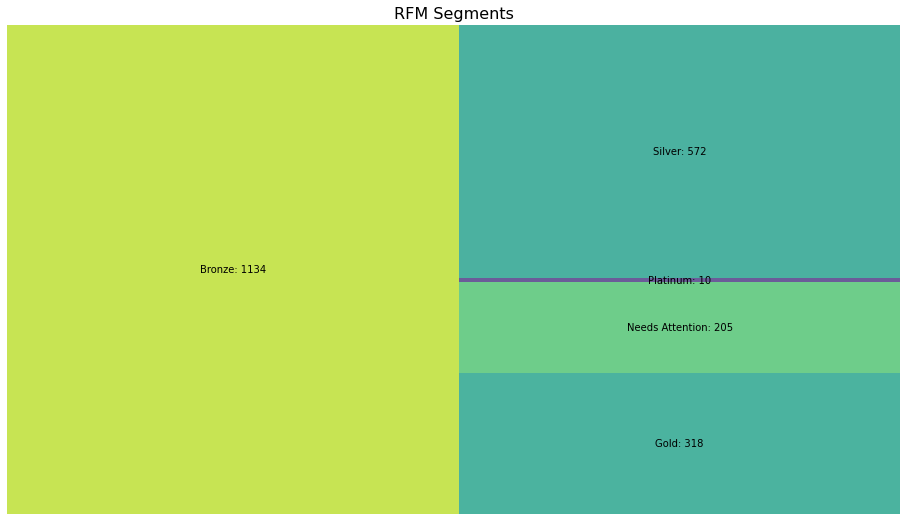

In [37]:
#Show mean and count, rounded by 1
rfm_level_agg = base_table.groupby('RFM_Level').agg({
    'recency': 'mean',
    'frequency': 'mean',
    'monetaryvalue': ['mean', 'count']
}).round(1)
print(rfm_level_agg)
#list of segment count for graph
customersbylevel = base_table.groupby('RFM_Level')['monetaryvalue'].agg('count').round(1)
#Create plot

fig = plt.gcf()
ax = fig.add_subplot()
fig.set_size_inches(16, 9)
#plot squares with the right label and count
squarify.plot(sizes=customersbylevel, 
              label=['Bronze: ' + str(customersbylevel[0]), 
                     'Gold: ' + str(customersbylevel[1]),
                     'Needs Attention: '+ str(customersbylevel[2]),
                     'Platinum: ' + str(customersbylevel[3]),
                     'Silver: ' + str(customersbylevel[4])], alpha=.8)
#Add title and remove axis
plt.title("RFM Segments",fontsize=16)
plt.axis('off')
plt.show()

In [38]:
#Clients by district
clients_by_district = base_table.groupby('district_id')['client_id'].agg('count')
clients_by_district = pd.DataFrame(clients_by_district)
clients_by_district = clients_by_district.reset_index()
clients_by_district = clients_by_district.rename(columns={'client_id':'no_of_clients'})
clients_by_district = pd.merge(clients_by_district,district[['district_id','district_name']],how='left',on='district_id')
clients_by_district = clients_by_district.sort_values(by='no_of_clients',ascending=False).head(10)

fig = plty.graph_objects.Figure()
fig.add_bar(x=clients_by_district['no_of_clients'],y=clients_by_district['district_name'],orientation='h')
fig.update_layout(title_text='Top 10 districts by clients',xaxis_title="No of Clients",
    yaxis_title="District")
fig.show()

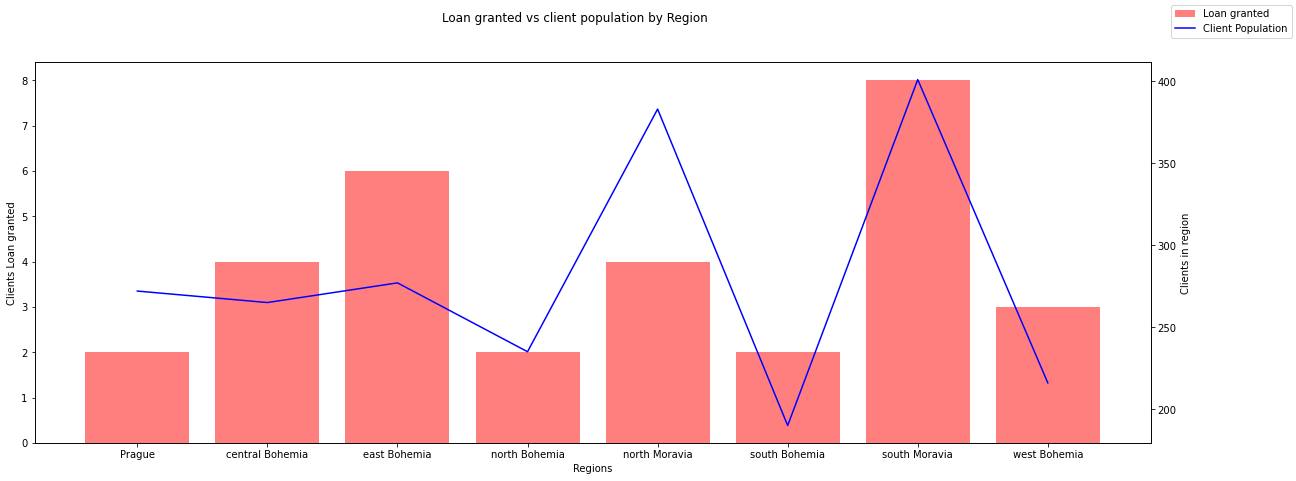

In [59]:
# Loans granted per Region
loan_grant_by_dist = base_table[base_table['loan_granted_97'] == 1]

loan_grant_by_dist = pd.merge(loan_grant_by_dist,district[['district_id','region']],how='left',on='district_id')
loan_by_region = pd.merge(base_table,district[['district_id','region']],how='left',on='district_id')

loan_grant_by_dist = loan_grant_by_dist.groupby('region')['client_id'].agg('count')
loan_by_region = loan_by_region.groupby('region')['client_id'].agg('count')

loan_grant_by_dist = loan_grant_by_dist.reset_index()
loan_by_region = loan_by_region.reset_index()

fig,ax1 = plt.subplots(figsize = (20,7))
ax1.bar(loan_grant_by_dist['region'],loan_grant_by_dist['client_id'],color = 'red',label = 'Loan granted',alpha=0.5)
ax2 = ax1.twinx()
ax2.plot(loan_by_region['region'],loan_by_region['client_id'],color = 'blue',label = 'Client Population')
fig.legend(loc = 1)
ax1.set_ylabel('Clients Loan granted')
ax2.set_ylabel('Clients in region')
ax1.set_xlabel('Regions')

fig.suptitle('Loan granted vs client population by Region')
plt.show()

In [92]:
#Distribution of loans granted and cards issued
labels_loan = ['Not granted','Granted']
labels_card = ['Not issued','issued']

fig = make_subplots(rows=1, cols=2, specs=[[{'type':'domain'}, {'type':'domain'}]])
fig.add_trace(plty.graph_objects.Pie(labels=base_table['loan_granted_97'], values=base_table['client_id'],
                                    textposition='outside',titleposition='top right',title='Loans granted',
                                    titlefont=dict(family="Arial",size=15)), 1, 1)
fig.add_trace(plty.graph_objects.Pie(labels=base_table['card_issued_97'], values=base_table['client_id'],
                                    textposition='outside',titleposition='top right',title='Cards Issued',
                                    titlefont=dict(family="Arial",size=15)),1, 2)
fig.update_layout(title_text = 'Percentage of loans and cards granted')
fig.update_coloraxes(col='green')

### Encode values after vizualizations

In [41]:
base_table['gender'] = np.where(base_table['gender'] == "M", 0 , 1)
base_table['age_group'] = base_table['age_group'].map({'Children':0,'Youth':1,'Adults':2,'Seniors':3})
base_table['Statement Frequency'] = base_table['Statement Frequency'].map({'After Trans':0,'Weekly':1,'Monthly':2})

## Machine Learning Models(Regression & Decision Tree)

In [42]:
#Logistic regression for Loan granted
selectedFeatures = []
exludefeatures = ('client_id','disp_id','account_id','loan_granted_97','loan_amount','loan_duration_months','duration_left','amount_left_to_pay','loan_payment')
target = "loan_granted_97"
select_feature_log_loan = []

for column in base_table.columns:
    if (column not in (exludefeatures)) & (is_numeric_dtype(base_table[column])):
        (pearson,pvalue) = pearsonr(base_table[column],base_table[target])
        select_feature_log_loan.append(f"{column} - p-vlue = {pvalue} - selected : {1 if pvalue < 0.005 else 0}")
        if pvalue < 0.001:
            selectedFeatures.append(column)

In [43]:
selectedFeatures

['acc_created_year',
 'lor',
 'total_order_amount',
 'order_miscellaneous',
 'opening_balance']

In [44]:
#Initialize X and Y
X = base_table[selectedFeatures]
y = base_table['loan_granted_97']
X = sm.add_constant(X) # add intercept (specific for statsmodels package)

#Split train and test
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)

# fit model
linreg = sm.OLS(y_train, X_train).fit()
linreg.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        loan_granted_97   R-squared:                       0.041
Model:                            OLS   Adj. R-squared:                  0.039
Method:                 Least Squares   F-statistic:                     19.04
Date:                Sat, 04 Dec 2021   Prob (F-statistic):           2.41e-15
Time:                        17:04:24   Log-Likelihood:                 1407.6
No. Observations:                1791   AIC:                            -2805.
Df Residuals:                    1786   BIC:                            -2778.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const               -9.936e-06   1.49e-06     -6.656      0.000   -1.29e-05   -7.01e-06
acc_created_year     1.738e-05   4.46e-06      3.895      0.000    8.63e-06    2.61e-05
lor                    -0.0198      0.003     -6.655      0.000      -0.026      -0.014
total_order_amount   3.085e-06   7.43e-07      4.153      0.000    1.63e-06    4.54e-06
order_miscellaneous  1.586e-06    1.9e-06      0.834      0.405   -2.14e-06    5.32e-06
opening_balance       1.61e-07   1.14e-07      1.411      0.158   -6.28e-08    3.85e-07
==============================================================================
Omnibus:                     2477.069   Durbin-Watson:                   2.018
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           354145.027
Skew:                           8.119   Prob(JB):                         0.00
Kurtosis:                      69.948   Cond. No.                     1.49e+20
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.85e-28. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [45]:
#Logistic regression for Card issued
selectedFeatures = []
exludefeatures = ('client_id','disp_id','account_id','card_issued_97','classic_card', 'gold_card', 'junior_card')
target = "card_issued_97"
select_feature_log_card = []
for column in base_table.columns:
    if (column not in (exludefeatures)) & (is_numeric_dtype(base_table[column])):
        (pearson,pvalue) = pearsonr(base_table[column],base_table[target])
        select_feature_log_card.append(f"{column} - p-vlue = {pvalue} - selected : {1 if pvalue < 0.005 else 0}")
        if pvalue < 0.001:
            selectedFeatures.append(column)

In [46]:
X = base_table[selectedFeatures]
y = base_table['card_issued_97']

X = sm.add_constant(X) # add intercept (specific for statsmodels package)
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)

# fit model
linreg = sm.OLS(y_train, X_train).fit()
linreg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         card_issued_97   R-squared:                       0.075
Model:                            OLS   Adj. R-squared:                  0.069
Method:                 Least Squares   F-statistic:                     13.10
Date:                Sat, 04 Dec 2021   Prob (F-statistic):           2.67e-24
Time:                        17:04:24   Log-Likelihood:                 180.77
No. Observations:                1791   AIC:                            -337.5
Df Residuals:                    1779   BIC:                            -271.7
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const                           -0.0091      0.061     -0.150      0.881      -0.128       0.110
total_credit_per_account     -2.946e-06   2.79e-05     -0.106      0.916   -5.76e-05    5.17e-05
total_withdrawal_per_account -3.434e-06   2.74e-05     -0.125      0.900   -5.71e-05    5.03e-05
opening_balance              -2.767e-07    3.5e-07     -0.791      0.429   -9.63e-07     4.1e-07
closing_balance               2.414e-06   5.22e-07      4.627      0.000    1.39e-06    3.44e-06
total_withdrawal_cash        -1.294e-07   1.34e-07     -0.968      0.333   -3.91e-07    1.33e-07
total_credit_cash            -2.589e-08   4.63e-08     -0.559      0.576   -1.17e-07    6.49e-08
total_miscellaneous           9.468e-06   1.24e-05      0.765      0.444   -1.48e-05    3.37e-05
monetaryvalue                 3.817e-06   2.74e-05      0.139      0.889   -4.99e-05    5.75e-05
avg_monthly_balance           1.069e-06   1.84e-07      5.803      0.000    7.08e-07    1.43e-06
average_salary_account        -1.49e-05    2.2e-05     -0.676      0.499   -5.81e-05    2.83e-05
M                                0.0355      0.024      1.461      0.144      -0.012       0.083
RFM_Score                       -0.0133      0.013     -1.029      0.304      -0.039       0.012
==============================================================================
Omnibus:                     1278.555   Durbin-Watson:                   1.938
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            13105.991
Skew:                           3.451   Prob(JB):                         0.00
Kurtosis:                      14.313   Cond. No.                     1.20e+17
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 6.44e-20. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

## Write base table to csv

In [47]:
base_table.to_csv('../data/processed/base_table.csv')

## Submitted by
![Team](../img/Team.jpeg)